In [1]:
import qiskit
from qiskit import QuantumCircuit
qiskit.__version__

'0.21.0'

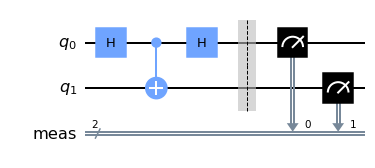

In [2]:
bomb_tester = QuantumCircuit(2)
# Hadamard gate
bomb_tester.h(0)
# C-NOT gate
bomb_tester.cx(0, 1)
# Hadamard gate
bomb_tester.h(0)
# Measure
bomb_tester.measure_all()
bomb_tester.draw(output='mpl')

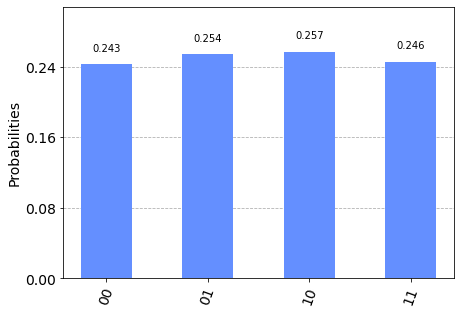

In [3]:
from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(bomb_tester, shots = 1000)
result = job.result()
counts = result.get_counts(bomb_tester)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [4]:
# photon qubit is the least significant bit
# 1 means the bomb/C-NOT gate is there
# the rest of the qubits is the bomb qubit
# 0 means the bomb didn't explode and 1 otherwise
# 01 is what we are looking for, it shows that the bomb-tester is working and the bomb did not explode

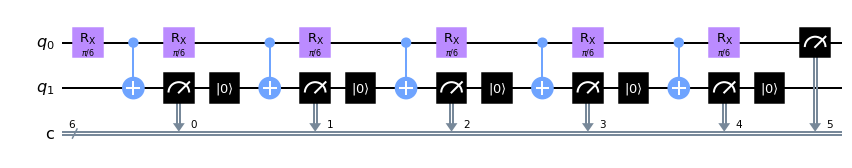

In [17]:
from qiskit.circuit import QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.circuit.library import RXGate

cycles = 6 # Number of times the photon passes through beam splitter, higher number = higher probability to not detonate the bomb
theta = np.pi/cycles # The correct reflectivity of beamsplitter is chosen for the quantum Zeno effect to work

#Create quantum circuit
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(cycles, 'c')
zeno_tester = QuantumCircuit(qr, cr)

# Create a chain of our variable beamsplitters and C-NOT bombs
for cycle in range(cycles-1):
    zeno_tester.append(RXGate(theta), [qr[0]])
    zeno_tester.cx(0, 1)
    zeno_tester.measure(qr[1], cr[cycle])
    zeno_tester.reset(qr[1])
    
# Add a final beamsplitter
zeno_tester.append(RXGate(theta), [qr[0]])

# Measure our photon to predict whether there is a bomb, and measure qubit to see if it exploded
zeno_tester.measure(qr[0], cr[cycles-1])
zeno_tester.draw(output='mpl')

In [18]:
# Each of the beamsplitters is a X rotation gate
# Using beamsplitters and C-NOT gate to simulate the photon passing through the beamsplitters lots of times 
# And measure each time after the photon passes through the beamsplitter to check if the bomb has exploded

{'100000': 36, '000000': 650, '111110': 54, '011000': 6, '100001': 1, '111111': 53, '111100': 46, '001110': 6, '000111': 3, '110000': 48, '011100': 5, '011111': 4, '111000': 57, '001111': 6, '001100': 4, '101100': 1, '000011': 1, '000110': 2, '011110': 3, '000001': 3, '001000': 3, '000010': 5, '010000': 1, '000100': 1, '100111': 1}


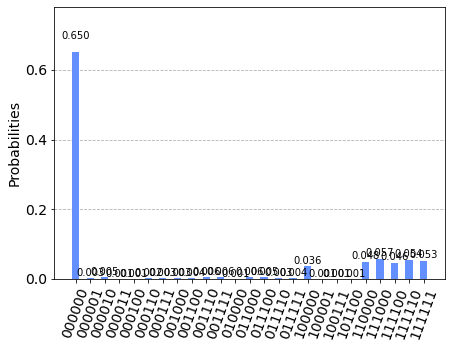

In [19]:
zeno_job = simulator.run(zeno_tester, shots = 1000)
zeno_result = zeno_job.result()
zeno_counts = zeno_result.get_counts(zeno_tester)
print(zeno_counts)
plot_histogram(zeno_counts)

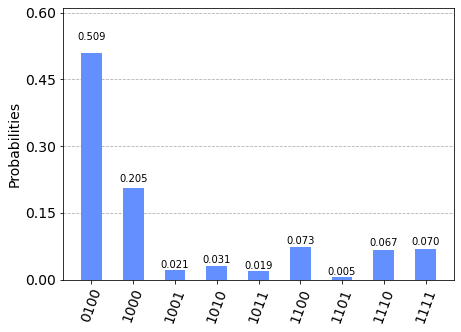

In [14]:
from qiskit.circuit.library import CCXGate

def quantum_sweeper(cycles) -> QuantumCircuit: 
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(cycles+1, 'c')
    qc = QuantumCircuit(qr, cr)
    qc.h(qr[0])
    for cycle in range(cycles - 1):
        qc.append(RXGate(theta), [qr[1]])
        qc.ccx(qr[0], qr[1], qr[2])
        qc.measure(qr[2], cr[cycle])
        if cycle < cycles -1:
            qc.reset(qr[2])
            
    qc.append(RXGate(theta), [qr[1]])
    qc.measure(qr[1], cr[cycles - 1])
    qc.measure(qr[0], cr[cycles])
    return qc

successes = 0
cycles = 3
theta = np.pi/cycles

zeno_circuit = quantum_sweeper(cycles)
zeno_job = simulator.run(zeno_circuit, shots = 1000)
zeno_result = zeno_job.result()
zeno_counts = zeno_result.get_counts(zeno_circuit)
plot_histogram(zeno_counts)

# zeno_circuit.draw(output='mpl')

In [ ]:
# Game of quantum minesweeper 
qsweeper_job = simulator.run(zeno_circuit, shots=1)
qsweeper_result = qsweeper_job.result()
qsweeper_counts = qsweeper_result.get_counts(zeno_circuit)

result = sorted(qsweeper_counts.keys())[0]

for i in range(2,cycles): # Check that none of the 3rd to last bits have flipped to a 1 
    if int(result[i]) == 1:
        print("BOOM! The bomb has exploded. You lose... :(")
        print("Your score was:") 
        print(successes)
        successes = 0
        explode = 1
        break
    else:
        explode = 0
    
if explode == 0:
    print("The qubit predicts...")
    if int(result[1]) == 0:
        print("Bomb present")
        Prediction = input("What do you think? Type 0 for no bomb, 1 for bomb.")
    else:
        print("No bomb")
        Prediction = input("What do you think? Type 0 for no bomb, 1 for bomb.")
        
    if Prediction == "0": 
        print("You predicted there is no bomb.")
    elif Prediction == "1":
        print("You predicted there is a bomb")
    else:
        print("Invalid prediction!")

    if Prediction == result[0]:
        print("Congratulations! You predicted correctly, you win Quantum Minesweeper! :D")
        successes += 1
    elif int(Prediction) == (int(result[0]) + 1) % 2:
        print("Uh oh! You predicted wrong. You lose :(")
        print("Your score was:") 
        print(successes)
        successes = 0
    else:
        print("Prediction was invalid so your score is unchanged.")
    
print("Quantum Minesweeper score:")
print(successes)

The qubit predicts...
No bomb
